# Programme principale sous forme de Notebook pour Training / Test / Inversion (version PL)


Notebook = `Main_TrainTestInversion_MultiMod_xtern_proc_pl_NB.ipynb`

#### Historic:

> **PL version**<br/>
> S.Thiria - C.Mejia, LOCEAN, Feb 2023

> **Adding plot_output_uniq_HIST_profils()**<br/>
> To plot Test output values and equivalent HIST forcings.<br/>
> C.Mejia, LOCEAN, Sept 1st, 2022

> **Original version**<br/>
> S.Thiria - C.Mejia, LOCEAN, Aout 2022
> Based on Train, Test and Inversion Notebooks from Guillaume Gastineau.

In [3]:
import os, sys
import numpy as np
#import matplotlib.pyplot as plt
#import pickle
from datetime import datetime as dt


import pandas as pd

import torch
#from torch.utils.data import DataLoader


/Users/dahmani/opt/anaconda3/envs/Data.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# To load personal libraries (currently in folder 'tools'):
sys.path.append('tools')

#import generic_tools_pl as gt   # like hexcolor(), ...
#import specific_nn_tools_pl as nnt  # like CustomDataset(), Net(), train_model() 
import generic_tools_pl as gt
from generic_tools_pl import region



In [5]:
gt.region="50"
region=gt.region
print(gt.region)

50


In [6]:

from training_proc_pl import train_procedure
import testing_proc_pl as tstp
import inverting_proc_pl as invp

In [7]:
!nvidia-smi
from torch.cuda import device_count

print(f'\nTorch version: {torch.__version__}')
if device_count() > 0:
    print('Torch has detected {0} GPUs compatible with CUDA:'.format(device_count()),end='')
    for device in np.arange(device_count()):
        print('\n  - torch cuda device=',torch.device(device),
              '\n    properties:',torch.cuda.get_device_properties(torch.device(device)))
else:
    print('Any Torch GPUs compatible with CUDA.')

if hasattr(torch.backends, 'mps') :
    # this verifies if the current current Pychch installation was built with MPS activated.
    if torch.backends.mps.is_built():# this ensures that the current current PyTorch installation was built with MPS activated.
        print("\nPyTorch installation was built with MPS activated!")
    else:
        print("\nPyTorch installation was not built with MPS activated. Maybe this is not a MacOS Monterrey platform with ARM processor?")
else:
    print("Current torch.backends doesn't have attribute 'mps' (this is usefull if you are in a MacOS Monterrey platform with ARM processor)")

# Call set_printoptions(threshold=x) to change the threshold where arrays are truncated. To prevent truncation, set the threshold to np.inf.
# Change linewidth to print wider lines ...
#display(np.get_printoptions())
if False:
    np.set_printoptions(threshold=np.inf,linewidth=180) # good for a 1920 pixels wide screen
    pd.set_option('display.max_columns', 18)            #
else:
    np.set_printoptions(threshold=np.inf,linewidth=300)   # good for an iMac 27" screen
    pd.set_option('display.max_columns', 30)              #

#pd.set_option('display.max_columns', 100)             # (this is maybe too much!)

zsh:1: command not found: nvidia-smi

Torch version: 1.13.1
Any Torch GPUs compatible with CUDA.

PyTorch installation was built with MPS activated!


In [8]:
verbose = False
#verbose = True
#--------------------
save_figs = True
#save_figs = False
#--------------------
figs_dir = 'Figs'

local_nb_label = "Nb5_TrainTestInvEssais-vPL0"   # label a appliquer aux noms des fichiers (figures) produits dans le notebook

fig_ext = 'png'
figs_defaults = { 'dpi' : 300, 'facecolor':'w', 'edgecolor' : 'w', 'format':fig_ext} # ajuter format='png' ou autre a l'appel de savefig()

if save_figs and not os.path.exists(figs_dir):
    os.makedirs(figs_dir)


___
## Exemple des paramètres identifiant les données à utiliser et les cas CNN à entrainer

Il faut en premier lieu renseigner les variables qui détermineront les données à utiliser:

>```python
># Exemples:
>#  Meta-variables impliquées dans le processus d'entrainement, non presentes explicitement dans ce Notebook:
>seed_for_combi = 0
>train_part = 0.85
>n_sim_for_train_by_mod = 132
>n_sim_max_for_test_by_mod = 100
>#
># La valeur de ces meta-variables composent les identifiants déterminant les ensembles TRAIN et TEST selon les expressions:
>train_set_label = f"{data_gener_method}-S{seed_for_combi}-GAN{train_part*100:.0f}pc-N{n_sim_for_train_by_mod}_v4"
>test_set_label = f"{data_gener_method}-S{seed_for_combi}-GAN{(1-train_part)*100:.0f}pc-NMx{n_sim_max_for_test_by_mod}_v4"
>```

>```python
>#  Mais dans ce Notebook, on declare directement la valeurs des identifiants, voici un exemple:
>data_gener_method = 'TTDGM2'
>train_set_label = f'{data_gener_method}-S0-GAN85pc-N132_v4'
>test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx100_v4'
># ce qui donne :
>    train_set_label égal à  'TTDGM2-S0-GAN85pc-n132_v4'
>    test_set_label égal à 'TTDGM2-S0-GAN15pc-NMx100_v4'
>#
># et on retrouve dans les identifiants les valeurs des meta-variables mentionnées ci-dessus.
># Dans les programmes appelés ici un procédé reverse est appliqué pour extraire à partir des labels les valeurs des meta-variables souhaités.
>```

In [9]:
# identifiant du réseau entrainé et des données TRAIN et TEST
#data_gener_method = 'TTDGM1'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N132_v4';    test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx100_v4'
#data_gener_method = 'TTDGM1'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N1000_v4';    test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx1000_v4'

#data_gener_method = 'TTDGM2'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N132_v4';    test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx100_v4'
data_gener_method = 'TTDGM2'; train_set_label = f'{data_gener_method}-S0-GAN85pc-N1000_z{region}v0';   test_set_label = f'{data_gener_method}-S0-GAN15pc-NMx1000_z{region}v0'


In [10]:
# identifiant des données INVERSION ---------------------------------------------------------------
inversion_suffix = 'INVDGM1-S1-NMx100_z{}v0'.format(region)
#inversion_suffix = 'INVDGM1-S1-NMx400_v4'   # *** (ce set de donnees n'existe plus, A VERIFIER Si BESOIN) ***
#inversion_suffix = 'INVDGM1-S1-NMx1000_v4'   # *** (ce set de donnees n'existe plus, A VERIFIER Si BESOIN) ***


In [11]:
# ether_dir = '/net/ether/data/varclim/ggalod/Constantin'

#data_dir = '/datatmp/data/constantin_data/data_source'
#data_dir = '/net/acratopotes/datatmp/data/constantin_data/data_source'
#data_dir = 'data'

# On lit le dataset de train
# Repertoire des donnees
try:
    # WORK dir carlos projet ryn sur Jean Zay
    data_dir = '/Users/dahmani/Desktop/GitPL/data_source_dr/Region{}'.format(region)
    if not os.path.isdir(data_dir):
        print(f" ** data_dir '{data_dir}' not found. Trying next...")
        
        # WORK dir Guillaume sur Jean Zay ** NON **
        #data_dir = '/gpfswork/rech/ryn/rces866/Constantin'
        #if not os.path.isdir(data_dir):
        #print(f" ** data_dir '{data_dir}' not found. Trying next...")
        
        # SSD sur Acratopotes au Locean
        data_dir = '/net/acratopotes/datatmp/data/constantin_data/data_source_pl'
        if not os.path.isdir(data_dir):
            print(f" ** data_dir '{data_dir}' not found. Trying next...")
            
            # sur Cloud SU (carlos)
            data_dir = os.path.expanduser('~/Clouds/SUnextCloud/Labo/Travaux/Theses-et-stages/These_Constantin/constantin_data/data_source_pl')
            if not os.path.isdir(data_dir):
                print(f" ** data_dir '{data_dir}' not found. Trying next...")
                
                # en dernier recours, en esperant qu'il y a un repertoire 'data' present ...
                data_dir = os.path.expanduser('data')
                if not os.path.isdir(data_dir):
                    print(f" ** data_dir '{data_dir}' not found at all **\n")
                    raise Exception('data_dir not found')

except Exception as e:
    print(f'\n *** Exception error "{e}" ***\n')
    raise

print(f"data_dir found at '{data_dir}'")

data_dir found at '/Users/dahmani/Desktop/GitPL/data_source_dr/Region50'


___
## Train

### _Train parameters_

In [12]:
# Validation set:
val_part_of_train_ok = True        # takes a percent of TRAIN (index_other from Train data) to be the VAL set (do nothing with index_model data)
val_part_of_train_fraction = 0.15  # valid only if val_part_of_train_ok is True
#val_part_of_train_ok = False      # takes all index_other from Train data for TRAIN and index_model for VAL

seed_before_training = 0

# ----------------------------------------------------------------------------------------------------
# Flag to decide to train with all models or to train indivudually each model (experiences jumelles)
do_train_with_all_models_flg = True
#do_train_with_all_models_flg = False

# ----------------------------------------------------------------------------------------------------
# Flag to force flatting NAT and HIST profiles (a low-pass foltering is applied to those forcings)
do_try_lp_nathist_filtering = True
#do_try_lp_nathist_filtering = False
if do_try_lp_nathist_filtering:
    # dictionary having the arguments for the scipy.signal.butter() function
    lp_nathist_filtering_dic = { 'n':4, 'Wn':[1./10.], 'btype':'lowpass' };
else:
    lp_nathist_filtering_dic = None

# ----------------------------------------------------------------------------------------------------
# Which model are in training
#models_to_train = ['ACCESS-ESM1-5', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'CESM2', 'FGOALS-g3', 'IPSL-CM6A-LR']
#models_to_train = ['FGOALS-g3', 'IPSL-CM6A-LR']
models_to_train = None   # if None then is all models !

# 
# if you want one or several neural nets trained with same conditions. 
n_nnets = 1
#n_nnets = 2
#n_nnets = 6

# ----------------------------------------------------------------------------------------------------
# Variables changing architecture of the Net
# ----------------------------------------------------------------------------------------------------
# Sizes of CNNs in the architecture (and implicitly the number of CNN (chained each to other)
# to be used in with the Net class function in specific_nn_tools.py file.
kernel_sizes = [7,7,7]
# ----------------------------------------------------------------------------------------------------
# number of channels in the CNNs
channel_sizes = 24;  # scalar or list same lenght as kernel_sizes

# ----------------------------------------------------------------------------------------------------
# Number of training epochs to execute
epochs = 300
#epochs = 1000
#epochs = 5000

# ----------------------------------------------------------------------------------------------------
# Other training parameters
batch_size = 100
learning_rate = 0.001
#learning_rate = 0.005

# ----------------------------------------------------------------------------------------------------
# various boooleens

plot_loss_figs = True

#do_train = True
do_train = False

do_test_experiences = True
#do_test_experiences = False

do_inversion_experiences = True
#do_inversion_experiences = False

local_train_extra_label = None
models_to_train_with_all = None

# ----------------------------------------------------------------------------------------------------
# Particularities

# In case of training once with all models we choose a model to act as identificator of the case, this
# is needed due to programing choices but do not change anything in results. You can choose any model 
if do_train_with_all_models_flg :
    models_to_train_with_all = 'IPSL-CM6A-LR'
    models_to_train = [ models_to_train_with_all ]  # we choose only one model in order to do only ONE learning.  In all cases and because do_train_with_all_models_flg is True, Trainig is composed of all data models.

    # This label will be added to the case identifier (and sub-folders where outputs in one side and figures
    # on the other will be saved). See the values of 'base_cases_list' returned by the train_procedure.
    local_train_extra_label = 'EssaiTRwAll2'


### Executing Training Procedure for all cases


Model names ... ['IPSL-CM6A-LR']
All years ..... 1850 to 2014

Training conditions:
 - train_case_extra_label .. EssaiTRwAll2
 - n_nnets ................. 1
 - epochs list ............. [300]
 - kernel sizes list ....... [[7, 7, 7]]
 - learnrates list ......... [0.001]
 - channel_sizes list ...... [[24]]
 - regul ................... 0.0005
 - extrap .................. no-extrap
 - log_scale_fig_loss ...... True

TRAINING START TIME: 2023-03-26 16:13:32.061843

Repertoire de base de sortie pour tous les Cas: './data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt/'

 ** filtering file './data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt/lp_nat_and_hist_filtering_param_dictionary.p'
 ** already exists. Filter parameters not saved **

------------------------------------------------------------------------------------------------------------------------------------
Training case 1) 'e300_bs100_Lr0.001-VfT15-TwALL' for modele 1/1)'IPSL-CM

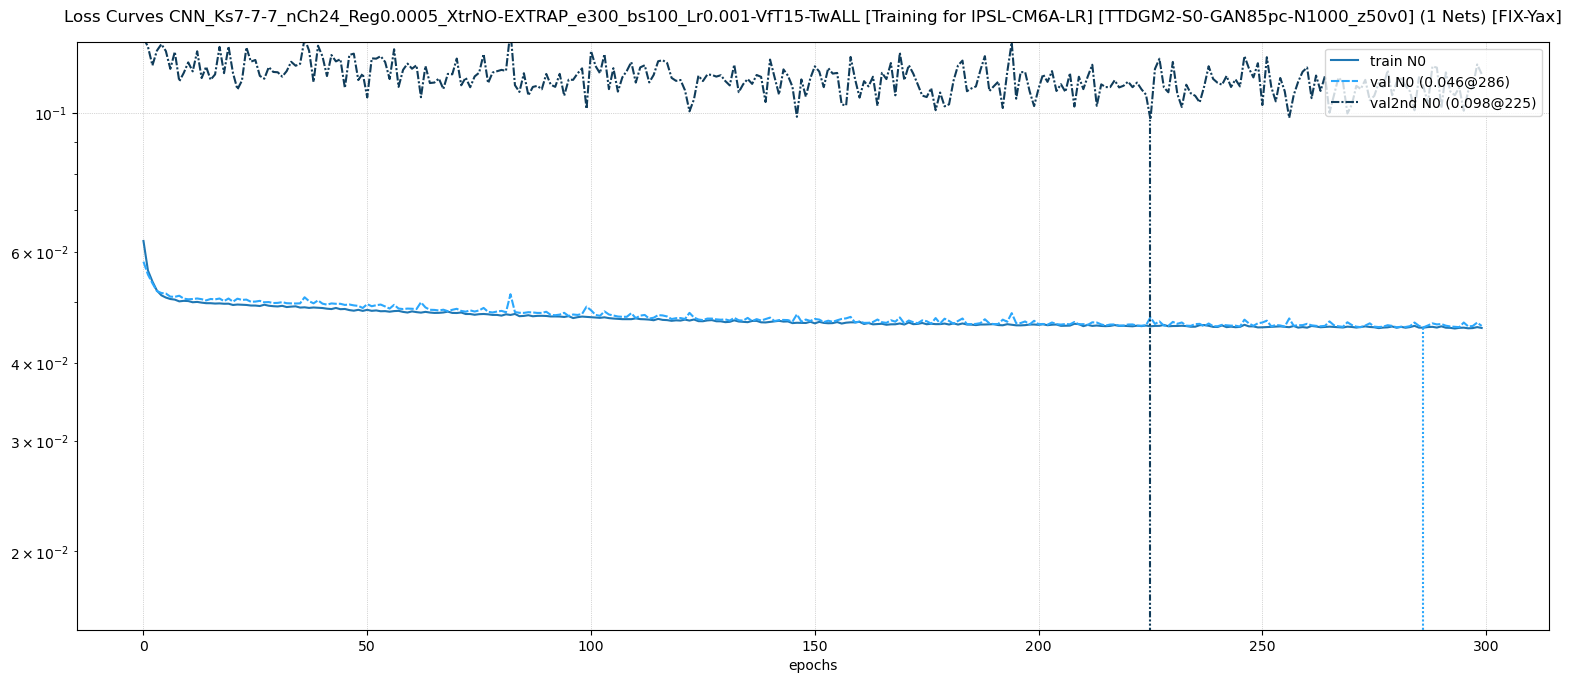


TRAINING INTERMEDIARY TIME: 2023-03-26 16:13:32.553829

<train_procedure done>


TRAINING START TIME at 2023-03-26 16:13:32.061843
            and END at 2023-03-26 16:13:32.553856

CPU times: user 3.03 s, sys: 361 ms, total: 3.39 s
Wall time: 1.93 s


In [13]:
%%time

# train_procedure arguments and options:
# -------------------------------------
#  data_gener_method, train_set_label, do_train=False, test_set_label=None,
#  train_case_extra_label=None, models_to_train=None,
#  train_with_all=False,
#  epochs=100, ksizes=[7,7,7], lr=0.001,
#  batch_size=100, channel_size=24, regul=0.0005, extrap="no-extrap", n_nnets=1,
#  lp_nathist_filtering=False, lp_nathist_filtering_dictionary=None,
#  lp_nathist_filtering_dic_file='lp_nat_and_hist_filtering_param_dictionary.p',
#  seed_before_training=0, log_scale_fig_loss=True, normalization_ok=False,
#  val_part_of_train_ok = False, val_part_of_train_fraction = 0.15,
#  data_in_dir=None, data_out_dir=None, figs_dir=None, plot_loss_figs=True, save_loss_figs=True,
#  local_nb_label="train_procedure", fig_ext='png',
#  figs_defaults={'dpi':300, 'facecolor':'w', 'edgecolor':'w', 'format':'png'},
#  verbose=False,

base_cases_list, sub_cases_list = train_procedure (data_gener_method, train_set_label, seed_before_training=seed_before_training,
                                                   train_case_extra_label=local_train_extra_label, models_to_train=models_to_train,
                                                   train_with_all=do_train_with_all_models_flg,
                                                   data_in_dir=data_dir,
                                                   epochs=epochs, n_nnets=n_nnets, batch_size=batch_size,
                                                   ksizes=kernel_sizes, channel_size=channel_sizes, lr=learning_rate,
                                                   val_part_of_train_ok = val_part_of_train_ok, val_part_of_train_fraction=val_part_of_train_fraction,
                                                   lp_nathist_filtering=do_try_lp_nathist_filtering, lp_nathist_filtering_dictionary=lp_nathist_filtering_dic,
                                                   figs_dir=figs_dir, plot_loss_figs=plot_loss_figs, save_loss_figs=save_figs,
                                                   local_nb_label=local_nb_label,
                                                   do_train=True,
                                                   #default_device='gpu', ngpu=1,
                                                   default_device='cpu',
                                                   verbose=verbose,
                                                  )

In [14]:
print(f"\n{'='*132}\n= Cases trained:")
for icas,(cas,scas) in enumerate(zip(base_cases_list, sub_cases_list)) :
    print(f"=   - Base case({icas}) .. '{cas}'")
    print(f"=     sub-case ...... '{scas}'")
print(f"{'='*132}\n")


= Cases trained:
=   - Base case(0) .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt'
=     sub-case ...... 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL'



In [15]:
#!ls -l data_out/out_v5_nn6-TTDGM2-S0-GAN85pc-N132_v4_12mod_NewNet_NHLpFilt/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15

#!ls -l data_out/out_v5_nn6-TTDGM2-S0-GAN85pc-N132_v4_12mod_NewNet/
#!ls -l data_out/out_v5_nn6-TTDGM2-S0-GAN85pc-N132_v4_12mod_NewNet/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e200_bs100_Lr0.001-VfT15/

___
## Test

### _For testing trained cases xe use the returned values `base_cases_list` and `sub_cases_list`_

### _Examples:_

`base_cases_list: ['out_v5_nn6-TTDGM2-S0-GAN85pc-N132_v4_12mod_NewNet']`<br/>
`sub_cases_list: ['CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e200_bs100_Lr0.001-VfT15']`


In [16]:
load_best_val_ok = True
#load_best_val_ok = False

#load_best_val2nd_ok = True   # Drive testing, no matter the value of 'load_best_val_ok' 
load_best_val2nd_ok = False  # if FALSE then 'load_best_val_ok' drives testing ...


In [17]:
plot_loss_curves_ok = True
#plot_loss_curves_ok = False

log_scale_fig_loss = True

errorlimits_percent = 0.9

test_set_prefix = 'test' # a modifier 
# test_set_prefix = 'train'
#test_set_prefix = 'inversion'  # PAS ENCORE INPLEMENTE

do_test_models = True
#do_test_models = False

do_test_table_all_models = True
#do_test_table_all_models = False

#plot_output_uniq_HIST_profile_ok = True
plot_output_uniq_HIST_profile_ok = False
plot_x_forcings_ok = True
#plot_x_forcings_ok = False
pouht_errorlimits_percent = errorlimits_percent

plot_mean_output_by_mod_on_HIST_profile_ok = True
#plot_mean_output_by_mod_on_HIST_profile_ok = False
pmobm_forcings_as_df = True
#pmobm_forcings_as_df = False
pmobm_show_x_all_forcings = True # a modifier 
pmobm_show_x_forcings = True  # a modifier 
pmobm_errorbars_on_pred = True
pmobm_errorlimits_percent = errorlimits_percent
pmobm_plot_forc_shaded_region = True   # if True fill_between, if False errorbars ...
pmobm_plot_pred_shaded_region = True   # if True fill_between, if False errorbars ...

if models_to_train is not None:
    models_to_test = models_to_train
else:
    models_to_test = None  # i.e: all models !


# inherit Training parameters
trained_with_all = do_train_with_all_models_flg

if trained_with_all:
    sample_model = models_to_train_with_all
    
    models_to_test_and_plot = model_names = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                             'NorESM2-LM']
    models_to_test_and_plot = model_names = [ 'BCC-CSM2-MR','IPSL-CM6A-LR' ]
    #models_to_test_and_plot = ['IPSL-CM6A-LR', 'CanESM5', 'MIROC6']
    #models_to_test_and_plot = None

else:
    sample_model = None
    models_to_test_and_plot = None

print('models_to_test_and_plot:',models_to_test_and_plot)

models_to_test_and_plot: ['BCC-CSM2-MR', 'IPSL-CM6A-LR']


In [18]:
if False:  # valeurs par defaut
    no_print_tables_test_proc = False
    force_write_loss_curves = False
    force_write_test_proc = False
    force_write_test_all_mod = False
    force_write_mse_figs = False
    force_plotandsave_uniq_H_profils = False

else:     # to force re-writing results
    no_print_tables_test_proc = True
    force_write_loss_curves = True
    force_write_test_proc = True
    force_write_test_all_mod = True
    force_write_mse_figs = True
    force_plotandsave_uniq_H_profils = True

#force_plotandsave_uniq_H_profils = True
#force_write_test_all_mod = True

no_print_tables_test_proc = True
#force_write_mse_figs = True

hist_t_limits = [-0.5, 1.6]   # plots Y axis fixed limits for HIST profils only
#hist_t_limits = None

all_forcings_t_limits = [-1.6, 2.52]   # plots Y axis fixed limits for all Forcings profils
#all_forcings_t_limits = None

if plot_x_forcings_ok :
    local_hist_t_limits = all_forcings_t_limits
else:
    local_hist_t_limits = hist_t_limits


### Test procedure for all models & all nnets

In [19]:
# from specific_nn_tools_pl import Net

# if do_test_experiences :

#     # particular case for Testing inversion data set
#     #if test_set_prefix == 'inversion':
#     #    another_label_to_test = inversion_suffix
#     #else:
#     another_label_to_test = None 
    
#     print("\n# Testing Trained Cases:\n")
#     for icase,(base_case_to_explore, sub_case_to_explore) in enumerate(zip(base_cases_list, sub_cases_list)) :
#         print(f"\n{'#'*132}#\n#  - Base case to explore({icase}) .. '{base_case_to_explore}'")
#         print(f"#    sub-case to explore ...... '{sub_case_to_explore}'")

#         ### Plotting (again) Training Loss curves

#         if plot_loss_curves_ok :
#             if do_try_lp_nathist_filtering :
#                 loss_min_limit,loss_max_limit = 0.006,0.15
#             else:
#                 loss_min_limit,loss_max_limit = 0.006,0.15
#                 #loss_min_limit,loss_max_limit = 0.015,0.15

#             tstp.plot_loss_curves(base_case_to_explore, sub_case_to_explore, 
#                                   models_to_plot=models_to_test,
#                                   loss_limits=[loss_min_limit,loss_max_limit],
#                                   save_also_free_fig=True,
#                                   log_scale=log_scale_fig_loss, figs_dir=figs_dir,
#                                   force_plot=force_write_loss_curves,
#                                   force_write=force_write_loss_curves,
#                                   verbose=verbose,
#                                  )
#         else:
#             print("\n ** plot loss curves not activated **\n")


#         ### Test procedure for all models & all nnets

#         if do_test_models :
#             #models_to_test = [ 'ACCESS-ESM1-5' ]

#             tstp.test_procedure(base_case_to_explore, sub_case_to_explore,
#                                 set_prefix_to_test=test_set_prefix,
#                                 data_in_dir=data_dir,
#                                 #another_label_to_use=another_label_to_test,
#                                 models_to_test=models_to_test_and_plot,
#                                 load_best_val=load_best_val_ok,
#                                 load_best_val2nd=load_best_val2nd_ok,
#                                 no_print_tables=no_print_tables_test_proc,
#                                 force_write=force_write_test_proc,
#                                 verbose=verbose)
#         else:
#             print(f"\n ** 'do_test_models' is not allowed **\n")


#         ### Table MSE and RMSE all models & all nnets

#         if do_test_table_all_models :
#             # models_to_test = [ 'ACCESS-ESM1-5' ]

#             return_test_table_all_models = tstp.build_test_table_all_models(base_case_to_explore, sub_case_to_explore,
#                                                                             trained_with_all=trained_with_all, sample_model=sample_model,
#                                                                             models_to_test=models_to_test_and_plot,
#                                                                             set_prefix_to_test=test_set_prefix, 
#                                                                             load_best_val=load_best_val_ok,
#                                                                             load_best_val2nd=load_best_val2nd_ok,
#                                                                             force_write=force_write_test_all_mod,
#                                                                             verbose=verbose)
#         else:
#             print(f"\n ** 'do_test_table_all_models' is not allowed **\n")
            

#         if plot_output_uniq_HIST_profile_ok :
#             #plot_together_uniq_HIST_output(base_case_to_explore, sub_case_to_explore,
#             #                               figs_dir=figs_dir, save_figs=save_figs,
#             #                               force_plot=True, force_write=True,
#             #                               verbose=False,
#             #                              )
#             tstp.plot_output_uniq_HIST_profils(base_case_to_explore, sub_case_to_explore,
#                                                trained_with_all=trained_with_all, sample_model=sample_model,
#                                                models_to_plot=models_to_test_and_plot,
#                                                set_prefix_to_test=test_set_prefix,
#                                                show_x_forcings=plot_x_forcings_ok,
#                                                errorlimits_percent=pouht_errorlimits_percent,
#                                                figs_dir=figs_dir, save_figs=save_figs,
#                                                load_best_val=load_best_val_ok,
#                                                load_best_val2nd=load_best_val2nd_ok,
#                                                t_limits=local_hist_t_limits,
#                                                force_plot=force_plotandsave_uniq_H_profils,
#                                                force_write=force_plotandsave_uniq_H_profils,
#                                                verbose=verbose,
#                                               )

#         else:
#             print(f"\n ** 'plot_output_uniq_HIST_profile_ok' is not allowed **\n")


#         if plot_mean_output_by_mod_on_HIST_profile_ok :
#             #plot_together_uniq_HIST_output(base_case_to_explore, sub_case_to_explore,
#             #                               figs_dir=figs_dir, save_figs=save_figs,
#             #                               force_plot=True, force_write=True,
#             #                               verbose=False,
#             #                              )
#             tstp.plot_mean_output_by_mod_on_HIST_profils(base_case_to_explore, sub_case_to_explore,
#                                                          trained_with_all=trained_with_all, sample_model=sample_model,
#                                                          models_to_plot=models_to_test_and_plot,
#                                                          source_dirname=data_dir,
#                                                          set_prefix_to_test=test_set_prefix, 
#                                                          show_x_all_forcings=pmobm_show_x_all_forcings,
#                                                          show_x_forcings=pmobm_show_x_forcings,
#                                                          plot_forc_shaded_region=pmobm_plot_forc_shaded_region,
#                                                          plot_pred_shaded_region=pmobm_plot_pred_shaded_region,
#                                                          errorlimits_percent=pmobm_errorlimits_percent,
#                                                          forcings_as_df=pmobm_forcings_as_df,
#                                                          figs_dir=figs_dir, save_figs=save_figs,
#                                                          load_best_val=load_best_val_ok,
#                                                          load_best_val2nd=load_best_val2nd_ok,
#                                                          t_limits=local_hist_t_limits,
#                                                          force_plot=force_plotandsave_uniq_H_profils,
#                                                          force_write=force_plotandsave_uniq_H_profils,
#                                                          errorbars_on_pred=pmobm_errorbars_on_pred,
#                                                          verbose=verbose,
#                                                         )

#         else:
#             print(f"\n ** 'plot_mean_output_by_mod_on_HIST_profile_ok' is not allowed **\n")

# else:
#     tmp_msg = f"'do_test_experiences' is not allowed"
#     print(f"\n {'*'*80}\n ** {tmp_msg:^74} **\n {'*'*80}\n")


In [20]:
#!ls -l ./data_out/out_v5_nn2-TTDGM2-S0-GAN85pc-N132_v4_1mod_EssaiTRwAll1/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15-TwALL/
#!ls -l ./data_out/out_v5_nn2-TTDGM2-S0-GAN85pc-N132_v4_1mod_EssaiTRwAll1/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15-TwALL/df_test-final-result-table_1-models_2-nnets_best-val_test-on-TEST-set_ST-TwALL.p

___
## Inversion

In [21]:
do_inverse_models = True
#do_inverse_models = False

# conditions for choosing profiles for inverson. By default NO Selection (nbest_to_choose = None)
nbest_to_choose = None        # give max number of profiles to invert for each model
choose_profiles_by_proximity_criterion = 'rmse' # method, for instance 'rmse' or 'dist' (quite the same)
period_to_choose = None       # tuple having initial-year and end-year (end-year can be -1), to be used as period to choose nearest hist profiles
#period_to_choose = (1965, -1)

take_xo_for_inversion_cost = False    # default #take_xo_for_cost=take_xo_for_inversion_cost
#take_xo_for_inversion_cost = True

do_mean_of_each_model_for_invert = False   # averaging individual forcings, by model, for inversion
# do_mean_of_each_model_for_invert = True  # invert individual forcings (Normal case)

# add_mean_of_all_for_invert = False # don't add mean of all forcings to invert
add_mean_of_all_for_invert = False   # add the mean of all forcings in inversion

# ----------------------------------------------------------------------------------------------------
# Flags to execute or not some procedures producing results or figures after inversion done
# ----------------------------------------------------------------------------------------------------

plot_averaged_inv_all_forcings_by_net_ok = True
#plot_averaged_inv_all_forcings_by_net_ok = False

inv_forc_shaded_region=False  #C'est pour ploter les barres d'erreur des donnees des modeles 


paiafbn_plot_forc_shaded_region = True   # if True fill_between, if False errorbars ...
paiafbn_errorlimits_percent = errorlimits_percent
#--------------- autorise ou non l'affichage des Forcage source pour le modele en cours.
#--------------- Apparait comme [+Xsrc] dans le titre, zt '_+XsrcMod]' dans le nom de la figure. 
#paiafbn_plot_src_Model_forc = True
paiafbn_plot_src_Model_forc = True 
#--------------- autorise ou non l'affichage des Forcage initiaux pour l'inversion en cours.
#--------------- Apparait comme [+Xini] dans le titre, et '_+XiniMod' dans le nom de la figure. 
paiafbn_plot_ini_forc = True
# paiafbn_plot_ini_forc = False
#---------------
#--------------- autorise ou non l'affichage des Forcage X inversés par l'inversion en cours.
#--------------- Apparait comme [+Xinv] dans le titre, et '_+XinvMod' dans le nom de la figure. 
paiafbn_plot_inv_forc = True
#paiafbn_plot_inv_forc = False

if models_to_train is not None:
    models_for_invert_and_plot = models_to_train
else:
    models_for_invert_and_plot = None  # i.e: all models !


hist_t_limits = [-0.5, 1.6]   # plots Y axis fixed limits for HIST profils
#hist_t_limits = None

all_forcings_t_limits = [-1.6, 2.52]   # plots Y axis fixed limits for HIST profils
#all_forcings_t_limits = None

# default values :
#    tmp_alpha=0.1; tmp_lr_opt=0.1; tmp_n_iter=200; tmp_delta_loss_limit=1e-7; tmp_patience=0
local_inv_n_iter = 600
local_inv_lr_reg = 0.2
local_inv_alpha  = 0.05
local_inv_lr_opt = 0.01

# inherit Training parameters
trained_with_all = do_train_with_all_models_flg

if trained_with_all:
    sample_model = models_to_train_with_all
#trained_with_all = False
#sample_model = None

number_of_multiobs=None
multiobs_choice_method='random'
multiobs_random_seed=0


In [22]:
if trained_with_all :
    if True:
        models_for_invert_and_plot = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                             'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                             'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                             'NorESM2-LM']
        # models_for_invert_and_plot = ['CNRM-CM6-1']
        #[ 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'CESM2', 'CNRM-CM6-1',
        #                              'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',
        #                              'IPSL-CM6A-LR',  'MIROC6',       'MRI-ESM2-0',  'NorESM2-LM' ]
        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3']
        # models_for_invert_and_plot += ['OBS']
        models_for_invert_and_plot = ['HadCRUT']
        # models_for_invert_and_plot += ['HadCRUT200']
        
        
        # number_of_multiobs=2
        # nbest_to_choose=150
        # period_to_choose=(1965,-1)

    else:
        models_for_invert_and_plot = ['IPSL-CM6A-LR']
        #models_for_invert_and_plot = ['CanESM5']
        #models_for_invert_and_plot = ['MIROC6']
        #models_for_invert_and_plot = ['IPSL-CM6A-LR', 'CanESM5', 'MIROC6', 'OBS']
        
        #models_for_invert_and_plot = ['OBS']
        
        #models_for_invert_and_plot = ['HadCRUT']
        #models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year
        
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=1; 
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year
        
        models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; 
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150
        #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year

else:
    models_for_invert_and_plot = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 
                                  'CNRM-CM6-1', 'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 
                                  'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0',
                                  'NorESM2-LM']
    models_for_invert_and_plot += ['OBS']
    models_for_invert_and_plot += ['HadCRUT']
    #models_for_invert_and_plot += ['HadCRUT200']; number_of_multiobs=1
    #models_for_invert_and_plot += ['HadCRUT200']; number_of_multiobs=1; nbest_to_choose=150

    #number_of_multiobs=1
    #number_of_multiobs=1; nbest_to_choose=150
    #number_of_multiobs=1; nbest_to_choose=150; period_to_choose=(1965,-1)

    #[ 'ACCESS-ESM1-5', 'BCC-CSM2-MR',  'CESM2', 'CNRM-CM6-1',
    #                              'CanESM5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL',
    #                              'IPSL-CM6A-LR',  'MIROC6',       'MRI-ESM2-0',  'NorESM2-LM' ]
    
    #models_for_invert_and_plot = ['OBS'];
    #models_for_invert_and_plot = ['OBS']; nbest_to_choose=150
    
    #models_for_invert_and_plot = ['HadCRUT'];
    #models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150
    #models_for_invert_and_plot = ['HadCRUT']; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year
    
    #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10
    #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150
    #models_for_invert_and_plot = ['HadCRUT200']; number_of_multiobs=10; nbest_to_choose=150; period_to_choose=(1965,-1)    # -1 means last year


do_try_lp_obs_filtering = do_try_lp_nathist_filtering
#do_try_lp_obs_filtering = True
#do_try_lp_obs_filtering = False
if do_try_lp_obs_filtering:
    # dictionary having the arguments for the scipy.signal.butter() function
    if type(lp_nathist_filtering_dic) is dict :
        lp_obs_filtering_dic = lp_nathist_filtering_dic
    else:
        lp_obs_filtering_dic = { 'n':4, 'Wn':[1./10.], 'btype':'lowpass' };
else:
    lp_obs_filtering_dic = None


In [23]:
if True:  # valeurs par defaut
    force_inverse_procedure = False
    force_inverted_hist_profiles = False
    force_average_inverted_profiles = False
    force_ave_inv_all_forc_by_model = False
    force_ave_inv_all_forc_by_net = False
    
else:     # to force re-writing results
    force_inverse_procedure = True
    force_inverted_hist_profiles = True
    force_average_inverted_profiles = True
    force_ave_inv_all_forc_by_model = True
    force_ave_inv_all_forc_by_net = True
    
#force_inverse_procedure = True
force_inverse_procedure = False

force_ave_inv_all_forc_by_net = True


### Inversion procedure and related output results, all models & all nnets

In [24]:
verbose_inv = False
#verbose_inv = True

verbose = False
# verbose = True

debug = False
#debug = True

In [25]:
if do_inversion_experiences :
    print("\n# Inversion procedure for Trained Cases:\n")
    for icase,(base_case_to_explore, sub_case_to_explore) in enumerate(zip(base_cases_list, sub_cases_list)) :
        print(f"\n{'#'*132}\n#  - Base case to explore({icase}) .. '{base_case_to_explore}'")
        print(f"#    sub-case to explore ...... '{sub_case_to_explore}'")

        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2', 'NorESM2-LM', 'GFDL-ESM4']
        #models_for_invert_and_plot = [ 'ACCESS-ESM1-5' ]
        #models_for_invert_and_plot = [ 'FGOALS-g3' ]
        #models_for_invert_and_plot = None

        current_inversion_settings_label, \
            current_inv_ssettings_sdir_dic = invp.inversion_procedure(base_case_to_explore, sub_case_to_explore, inversion_suffix,
                                                                      take_xo_for_cost=take_xo_for_inversion_cost,
                                                                       trained_with_all=trained_with_all, sample_model=sample_model,
                                                                       load_best_val=load_best_val_ok, load_best_val2nd=load_best_val2nd_ok,
                                                                       models_for_inversion=models_for_invert_and_plot,
                                                                       do_mean_of_each_model=do_mean_of_each_model_for_invert,
                                                                       data_in_dir=None,
                                                                       add_mean_of_all=add_mean_of_all_for_invert,
                                                                       inv_n_iter=local_inv_n_iter, inv_lr_reg=local_inv_lr_reg,
                                                                       inv_lr_opt=local_inv_lr_opt, inv_alpha=local_inv_alpha,
                                                                       do_inversion=do_inverse_models,
                                                                       force_inverse=force_inverse_procedure,
                                                                       lp_obs_filtering=do_try_lp_obs_filtering, lp_obs_filtering_dictionary=lp_obs_filtering_dic,
                                                                       number_of_multiobs=number_of_multiobs, multiobs_choice_method=multiobs_choice_method, multiobs_random_seed=multiobs_random_seed,
                                                                       nbest_to_choose=nbest_to_choose, choose_profiles_by_proximity_criterion=choose_profiles_by_proximity_criterion, 
                                                                       period_to_choose=period_to_choose, 
                                                                    #    default_device='gpu', ngpu=0,
                                                                       default_device='cpu',
                                                                       verbose_inv=verbose_inv,  verbose=verbose, debug=debug)


# Inversion procedure for Trained Cases:


####################################################################################################################################
#  - Base case to explore(0) .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt'
#    sub-case to explore ...... 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL'
Repertoire de base de entree-sortie pour tous les Cas: './data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt/'
Loading filtering parameters from file './data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt/lp_nat_and_hist_filtering_param_dictionary.p'

Lecture des meta donnees (ALL_sim, liste de modeles, ...) ...

Reading forcing data files ...
 Data 'T_ghg_z50v0.p' -> dim: (103, 165)
0 3
3 6
6 9
9 17
17 67
67 70
70 80
80 84
84 92
92 95
95 100
100 103
 Data 'T_aer_z50v0.p' -> dim: (89, 165)
0 3
3 6
6 8
8 16
16 46
46 49
49 59
59 63
63 71
71 81
81 86
86 89
 Dat

# Elapsed Time exemples:

For the inversion of one profile only, the 'OBS' profile. The inversion don't do a efficient use of GPU parallelism, it's better doing it using CPU device.

## Inversion of the 'OBS' profile:
```
cpu on iMac 27 2020, Intel Core i5 @ 3.3 GHz 6 coeurs                 28.6 s
cpu on Acratopotes, Intel(R) Xeon(R) W-2145 CPU @ 3.70GHz 8 coeurs    29.8 s (with another process running)
gpu=1 on Acratopotes, "Quadro RTX 5000"                              181.0 s (180.1 s the second try inmediatelly after) with another process running the other gpu
gpu=0 on Acratopotes"NVIDIA RTX A5000"                               176.3 s (97.4 s the second try inmediatelly after) with another process running in same gpu.
```

## Inversion of the 'HadCRUT' profile:
```
cpu on iMac 27 2020, Intel Core i5 @ 3.3 GHz 6 coeurs                 28.4 s
cpu on Acratopotes, Intel(R) Xeon(R) W-2145 CPU @ 3.70GHz 8 coeurs    32.5 s
gpu=1 on Acratopotes, "Quadro RTX 5000"                              190.2 s
gpu=0 on Acratopotes, "NVIDIA RTX A5000"                             199.4 s (115 s the second try inmediatelly after) with another process running in same gpu.
```


In [26]:
base_cases_list,sub_cases_list

(['out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt'],
 ['CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL'])

In [27]:
#models_for_invert_and_plot.remove('OBS')
print('models_for_invert_and_plot:- ......',models_for_invert_and_plot)
print('current_inversion_settings_label ..',current_inversion_settings_label)
print('current_inv_ssettings_sdir_dic ....',current_inv_ssettings_sdir_dic)

models_for_invert_and_plot:- ...... ['HadCRUT']
current_inversion_settings_label .. Lr0.2-Opt0.01-A0.05_INVDGM1-S1-NMx100_z50v0
current_inv_ssettings_sdir_dic .... {'HadCRUT': 'ALL1_best-val-net'}



# Inversion procedure for Trained Cases:


####################################################################################################################################
#  - Base case to explore(0) .. 'out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt'
#    sub-case to explore ...... 'CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL'
Repertoire de base de entree-sortie pour tous les Cas: './data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt/'
Loading filtering parameters from file './data_out/out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt/lp_nat_and_hist_filtering_param_dictionary.p'

Lecture des meta donnees (ALL_sim, liste de modeles, ...) ...

Reading forcing data files ...
 Data 'T_ghg_z50v0.p' -> dim: (103, 165)
0 3
3 6
6 9
9 17
17 67
67 70
70 80
80 84
84 92
92 95
95 100
100 103
 Data 'T_aer_z50v0.p' -> dim: (89, 165)
0 3
3 6
6 8
8 16
16 46
46 49
49 59
59 63
63 71
71 81
81 86
86 89
 Dat

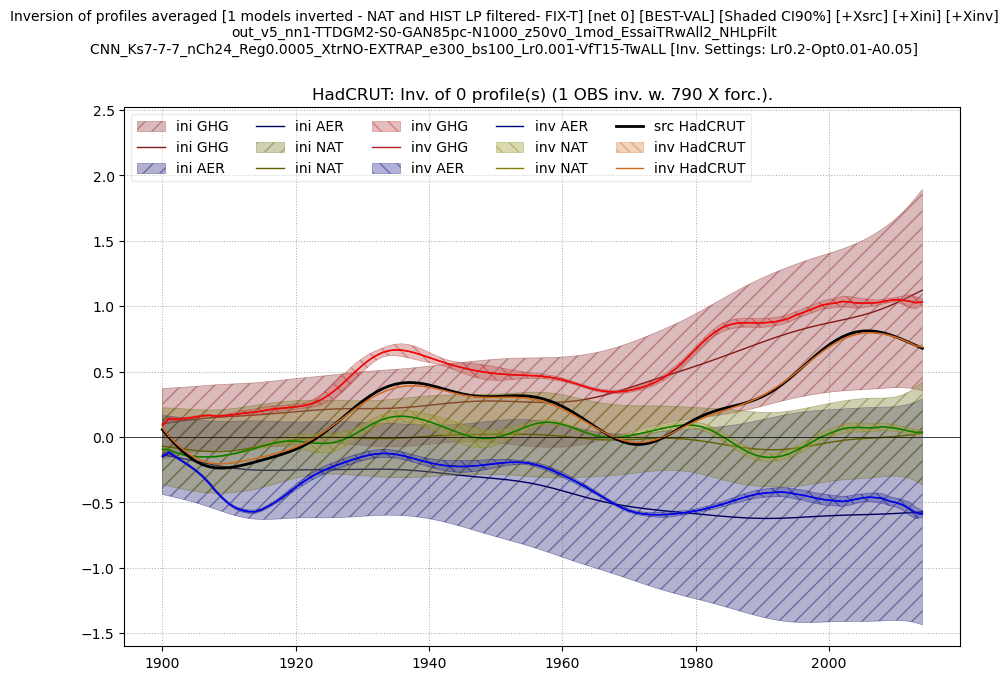

In [28]:
if do_inversion_experiences :
    models_for_invert_and_plot_backup = models_for_invert_and_plot
    all_models_for_invert_and_plot = models_for_invert_and_plot
    
    print("\n# Inversion procedure for Trained Cases:\n")
    for icase,(base_case_to_explore, sub_case_to_explore) in enumerate(zip(base_cases_list, sub_cases_list)) :
        print(f"\n{'#'*132}\n#  - Base case to explore({icase}) .. '{base_case_to_explore}'")
        print(f"#    sub-case to explore ...... '{sub_case_to_explore}'")

        #models_for_invert_and_plot = ['BCC-CSM2-MR', 'FGOALS-g3', 'CanESM5', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2', 'NorESM2-LM', 'GFDL-ESM4']
        #models_for_invert_and_plot = [ 'ACCESS-ESM1-5' ]
        #models_for_invert_and_plot = [ 'FGOALS-g3' ]
        #models_for_invert_and_plot = None

        for models_for_invert_and_plot in all_models_for_invert_and_plot :
            if np.isscalar(models_for_invert_and_plot) :
                models_for_invert_and_plot = [models_for_invert_and_plot]

            ## Plot inverted averaged by model all forcings profiles, show all models, by net

            if plot_averaged_inv_all_forcings_by_net_ok :
                #models_to_plot = [ 'NorESM2-LM' ]
                #models_to_plot = [ 'IPSL-CM6A-LR' ]
                #models_to_plot = [ 'FGOALS-g3' ]
                models_to_plot = models_for_invert_and_plot
                #models_to_plot = None
                invp.plot_averaged_inv_all_forcings_by_net(base_case_to_explore, sub_case_to_explore, inversion_suffix,
                                                                   trained_with_all=trained_with_all,
                                                                   settings_label=current_inversion_settings_label,
                                                                   plot_src4inv=paiafbn_plot_src_Model_forc,
                                                                   plot_ini_x=paiafbn_plot_ini_forc,
                                                                   plot_inv_x=paiafbn_plot_inv_forc,
                                                                   sset_sdir_dic=current_inv_ssettings_sdir_dic,
                                                                   load_best_val=load_best_val_ok, load_best_val2nd=load_best_val2nd_ok, 
                                                                   figs_dir=figs_dir, save_figs=save_figs,
                                                                   models_to_plot=models_to_plot,
                                                                   lp_obs_filtering=do_try_lp_obs_filtering, lp_obs_filtering_dictionary=lp_obs_filtering_dic,
                                                                   force_plot=force_ave_inv_all_forc_by_net, force_write=force_ave_inv_all_forc_by_net,
                                                                   t_limits=all_forcings_t_limits,
                                                                   plot_forc_shaded_region=paiafbn_plot_forc_shaded_region,
                                                                   plot_inv_forc_shaded_region=inv_forc_shaded_region, 
                                                                   errorlimits_percent=paiafbn_errorlimits_percent,
                                                                   verbose=verbose,
                                                                  )
                # invp.plot_averaged_inv_all_forcings_by_net(base_case_to_explore, sub_case_to_explore, inversion_suffix,
                #                                            trained_with_all=trained_with_all,
                #                                            settings_label=current_inversion_settings_label,
                #                                            sset_sdir_dic=current_inv_ssettings_sdir_dic,
                #                                            load_best_val=load_best_val_ok, load_best_val2nd=load_best_val2nd_ok, 
                #                                            figs_dir=figs_dir, save_figs=save_figs,
                #                                            models_to_plot=models_to_plot,
                #                                            lp_obs_filtering=do_try_lp_obs_filtering, lp_obs_filtering_dictionary=lp_obs_filtering_dic,
                #                                            force_plot=force_ave_inv_all_forc_by_net, force_write=force_ave_inv_all_forc_by_net,
                #                                            t_limits=all_forcings_t_limits,
                #                                            plot_forc_shaded_region=paiafbn_plot_forc_shaded_region,
                #                                            errorlimits_percent=paiafbn_errorlimits_percent,
                #                                            verbose=verbose,
                #                                           )
            else:
                print(f" ** 'plot_averaged_inv_all_forcings_by_net_ok' is not allowed **\n")

    models_for_invert_and_plot = models_for_invert_and_plot_backup

else:
    tmp_msg = f"'do_inversion_experiences' is not allowed"
    print(f"\n {'*'*80}\n ** {tmp_msg:^74} **\n {'*'*80}\n")

In [29]:
#!ls -l ./data_out/out_v5_nn2-TTDGM2-S0-GAN85pc-N132_v4_1mod_EssaiTRwAll1/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15-TwALL/
#!ls -l ./data_out/out_v5_nn2-TTDGM2-S0-GAN85pc-N132_v4_1mod_EssaiTRwAll1/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15-TwALL/Inversion-on_BCC-CSM2-MR/
#!ls -l ./data_out/out_v5_nn2-TTDGM2-S0-GAN85pc-N132_v4_1mod_EssaiTRwAll1/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15-TwALL/Inversion-on_BCC-CSM2-MR/Inv_N0
#!ls -l ./data_out/out_v5_nn2-TTDGM2-S0-GAN85pc-N132_v4_1mod_EssaiTRwAll1/CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e1000_bs100_Lr0.001-VfT15-TwALL/Inversion-on_BCC-CSM2-MR/Inv_N0/Settings-*


In [30]:
print(f"\nFIN d'Execution [{local_nb_label}]:\n  base_case_to_explore ... {base_case_to_explore}\n  sub_case_to_explore .... {sub_case_to_explore}\n  Date/heure d'arret ..... {dt.now()}")


FIN d'Execution [Nb5_TrainTestInvEssais-vPL0]:
  base_case_to_explore ... out_v5_nn1-TTDGM2-S0-GAN85pc-N1000_z50v0_1mod_EssaiTRwAll2_NHLpFilt
  sub_case_to_explore .... CNN_Ks7-7-7_nCh24_Reg0.0005_XtrNO-EXTRAP_e300_bs100_Lr0.001-VfT15-TwALL
  Date/heure d'arret ..... 2023-03-26 16:13:34.434985
